# Read in FY2025

Import your packages

In [137]:
import Pkg
# This installs only the modern, compatible versions
Pkg.add(["DataFrames", "CSV", "StatsPlots", "Statistics", "XLSX", "Dates", "StatsBase"])

   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


Read in your file

In [138]:
using DataFrames, CSV

filename = "backups/extracted/FY2025/All_Contracts_PrimeTransactions_2026-01-27_H16M01S18_1.csv"
# Using 'limit=10' to save your PC's energy
df = CSV.read(filename, DataFrame) #, limit=10000)
first(df, 5)



Row,contract_transaction_unique_key,contract_award_unique_key,award_id_piid,modification_number,transaction_number,parent_award_agency_id,parent_award_agency_name,parent_award_id_piid,parent_award_modification_number,federal_action_obligation,total_dollars_obligated,total_outlayed_amount_for_overall_award,base_and_exercised_options_value,current_total_value_of_award,base_and_all_options_value,potential_total_value_of_award,disaster_emergency_fund_codes_for_overall_award,outlayed_amount_from_COVID-19_supplementals_for_overall_award,obligated_amount_from_COVID-19_supplementals_for_overall_award,outlayed_amount_from_IIJA_supplemental_for_overall_award,obligated_amount_from_IIJA_supplemental_for_overall_award,action_date,action_date_fiscal_year,period_of_performance_start_date,period_of_performance_current_end_date,period_of_performance_potential_end_date,ordering_period_end_date,solicitation_date,awarding_agency_code,awarding_agency_name,awarding_sub_agency_code,awarding_sub_agency_name,awarding_office_code,awarding_office_name,funding_agency_code,funding_agency_name,funding_sub_agency_code,funding_sub_agency_name,funding_office_code,funding_office_name,treasury_accounts_funding_this_award,federal_accounts_funding_this_award,object_classes_funding_this_award,program_activities_funding_this_award,foreign_funding,foreign_funding_description,sam_exception,sam_exception_description,recipient_uei,recipient_duns,recipient_name,recipient_name_raw,recipient_doing_business_as_name,cage_code,recipient_parent_uei,recipient_parent_duns,recipient_parent_name,recipient_parent_name_raw,recipient_country_code,recipient_country_name,recipient_address_line_1,recipient_address_line_2,recipient_city_name,prime_award_transaction_recipient_county_fips_code,recipient_county_name,prime_award_transaction_recipient_state_fips_code,recipient_state_code,recipient_state_name,recipient_zip_4_code,prime_award_transaction_recipient_cd_original,prime_award_transaction_recipient_cd_current,recipient_phone_number,recipient_fax_number,primary_place_of_performance_country_code,primary_place_of_performance_country_name,primary_place_of_performance_city_name,prime_award_transaction_place_of_performance_county_fips_code,primary_place_of_performance_county_name,prime_award_transaction_place_of_performance_state_fips_code,primary_place_of_performance_state_code,primary_place_of_performance_state_name,primary_place_of_performance_zip_4,prime_award_transaction_place_of_performance_cd_original,prime_award_transaction_place_of_performance_cd_current,award_or_idv_flag,award_type_code,award_type,idv_type_code,idv_type,multiple_or_single_award_idv_code,multiple_or_single_award_idv,type_of_idc_code,type_of_idc,type_of_contract_pricing_code,type_of_contract_pricing,transaction_description,prime_award_base_transaction_description,action_type_code,action_type,solicitation_identifier,⋯
,String,String,String31,String7,Int64?,Int64?,String?,String31?,String31?,Float64,Float64,Float64?,Float64?,Float64?,Float64,Float64,String?,Float64?,Float64?,Missing,Missing,Date,Int64,Date,Date?,String31?,Date?,Date?,Int64,String31,Int64,String31,String7,String,Int64,String,String7,String,String7,String,String?,String?,String?,String?,String1,String31,Int64?,String?,String15,Missing,String,String,String?,String7?,String15?,Missing,String?,String?,String3,String15,String,String?,String31,Int64?,String31?,Int64?,String3,String31,String15,String7?,String7,String15?,String15?,String3?,String?,String31?,Int64?,String31?,Int64?,String3?,String31?,String15?,String7?,String7?,String7,String1?,String31?,String1?,String3?,String1?,String15?,String1?,String?,String1,String,String,String?,String1?,String?,String15?,⋯
1,9700_-NONE-_FA226323C0002_P00045_-NONE-_0,CONT_AWD_FA226323C0002_9700_-NONE-_-NONE-,FA226323C0002,P00045,0,missing,missing,missing,missing,7.77366e5,5.62032e7,missing,7.77366e5,5.65587e7,7.77366e5,1.82167e8,Q: Not Designated Nonemergency/Emergency/Disaster/Wildfire Suppression,missing,missing,mis

print ur data dicationary (complete)

In [143]:
# 1. Pick a specific contract to audit
target_id = "CONT_AWD_FA521514C7007_9700_-NONE-_-NONE-"


# 2. Filter the original dataframe (before grouping)
contract_history = filter(row -> row.contract_award_unique_key == target_id, df)

# 3. Sort it chronologically to see the "Story"
sort!(contract_history, :modification_number)

# 4. View the results
show(contract_history, allcols=true)

33×297 DataFrame
 Row │ contract_transaction_unique_key    contract_award_unique_key          award_id_piid  modification_number  transaction_number  parent_award_agency_id  parent_award_agency_name  parent_award_id_piid  parent_award_modification_number  federal_action_obligation  total_dollars_obligated  total_outlayed_amount_for_overall_award  base_and_exercised_options_value  current_total_value_of_award  base_and_all_options_value  potential_total_value_of_award  disaster_emergency_fund_codes_for_overall_award  outlayed_amount_from_COVID-19_supplementals_for_overall_award  obligated_amount_from_COVID-19_supplementals_for_overall_award  outlayed_amount_from_IIJA_supplemental_for_overall_award  obligated_amount_from_IIJA_supplemental_for_overall_award  action_date  action_date_fiscal_year  period_of_performance_start_date  period_of_performance_current_end_date  period_of_performance_potential_end_date  ordering_period_end_date  solicitation_date     awarding_agency_code  awarding_a

# Data Cleaning Steps

## Step 1: Remove duplicates
1. sort by key and then modification number (descending)
2. group by the Unique Key and take the 'first' row of each group to represent the latest 

<div class="alert alert-info">
<b>Note:</b> dataframe is called <b>df_latest</b> after this step.
</div>


In [140]:
using DataFrames

# 1. Sort by Key and then by Modification Number and then by transaction_number (descending)
# We convert modification_number to string/int carefully to ensure "10" comes after "2"
sort!(df, [:contract_award_unique_key, order(:modification_number, rev=true), order(:transaction_number, rev=true)])
# 2. Group by the Unique Key and take the 'first' row of each group
# Because we sorted 'rev=true', the 'first' row is the latest modification
df_latest = combine(groupby(df, :contract_award_unique_key), first)
# 3. Verify the counts match your 57,969 unique values
println("New row count: ", nrow(df_latest))

New row count: 57969


In [142]:
using DataFrames

# Assuming your DataFrame is named 'df' and column is ':my_column'
count(ismissing, df_latest.total_dollars_obligated) # Count of missing values

0

## Step 2: Select desireable columns and convert datatypes 
- Keeps only valuable columns defined in TODAY's headers.
<div class="alert alert-info">
<b>Note:</b> dataframe is called <b> df_clean</b> after this step.
</div>

In [ ]:
using DataFrames, CSV, Dates, Statistics

# --- 1. SETUP & FILTERING ---

# Load mapping file once
mapping_df = CSV.read("data/headers/desired-headers-from-fy2025-02262026.csv", DataFrame)

# Filter for "yes" columns and create a Map for the types
# We build a dictionary where Column Name => Ideal Type
active_mapping = filter(row -> lowercase(strip(string(row."keep?"))) == "yes", mapping_df)
type_map = Dict(string(r.variable) => lowercase(strip(string(r["ideal type"]))) for r in eachrow(active_mapping))

# Get only the columns that actually exist in your data to prevent crashes
existing_cols = names(df_latest)
target_cols = collect(intersect(keys(type_map), existing_cols))

# Create df_clean with only the columns we want
df_clean = select(df_latest, target_cols)

# --- 2. THE CONVERSION ENGINE ---

function safe_convert(col_data, target)
    if target == "int"
        return map(x -> begin
            if ismissing(x) || x == "" return missing end
            try return Int(round(parse(Float64, string(x)))) catch; return missing end
        end, col_data)
    elseif target == "float"
        return map(x -> ismissing(x) || x == "" ? missing : tryparse(Float64, string(x)), col_data)
    elseif target == "bool"
        return map(x -> begin
            if ismissing(x) return missing end
            s = lowercase(strip(string(x)))
            if s in ("true", "t", "y", "yes", "1", "1.0", "s") return true
            elseif s in ("false", "f", "n", "no", "0", "0.0", "o", "x") return false
            else return missing end
        end, col_data)
    elseif target == "date"
        return map(x -> begin
            if ismissing(x) || x == "" return missing end
            try return Date(first(string(x), 10)) catch; return missing end
        end, col_data)
    elseif target == "str" || target == "string"
        return map(x -> ismissing(x) ? missing : string(x), col_data)
    else
        return col_data 
    end
end

# --- 3. EXECUTION ---

for col_name in target_cols
    s_name = string(col_name)
    ideal = type_map[s_name]
    # Use [!, col_name] to modify the column in-place for efficiency
    df_clean[!, col_name] = safe_convert(df_clean[!, col_name], ideal)
end

println("🚀 Pipeline Complete!")
println("Final DataFrame: $(ncol(df_clean)) columns processed.")

🚀 Pipeline Complete!
Final DataFrame: 82 columns processed.


### 2.1 EDA Aside: Evaluate boolean columns to see if they are valuable (variance analysis)

In [36]:
# 4. Boolean Column Analysis
println("\n" * "="^40)
println("      BOOLEAN COLUMN ANALYSIS")
println("="^40)

# Identify columns that are now Boolean (allowing for missing)
bool_cols = [n for n in names(df_clean) if eltype(df_clean[!, n]) <: Union{Bool, Missing}]

if isempty(bool_cols)
    println("No boolean columns found.")
else
    for col in bool_cols
        vals = df_clean[!, col]
        total = length(vals)
        m_count = sum(ismissing.(vals))
        
        # If the whole column is missing, skip the math to avoid the ArgumentError
        if m_count == total
            println("Column: $col")
            println("  ⚠️  ALL VALUES ARE MISSING")
            println("-" ^ 40)
            continue
        end

        # Calculate counts safely
        # Using count() is more robust than sum(skipmissing()) for empty sets
        t_count = count(x -> !ismissing(x) && x == true, vals)
        f_count = count(x -> !ismissing(x) && x == false, vals)
        
        valid_total = t_count + f_count
        t_perc = valid_total > 0 ? round((t_count / valid_total) * 100, digits=2) : 0.0
        f_perc = valid_total > 0 ? round((f_count / valid_total) * 100, digits=2) : 0.0

        println("Column: $col")
        println("  [✔] TRUE:  $t_count ($t_perc%)")
        println("  [✖] FALSE: $f_count ($f_perc%)")
        println("  [?] MISSING: $m_count")
        println("-" ^ 40)
    end
end


      BOOLEAN COLUMN ANALYSIS
Column: fed_biz_opps_code
  [✔] TRUE:  21894 (41.98%)
  [✖] FALSE: 30262 (58.02%)
  [?] MISSING: 5813
----------------------------------------
Column: clinger_cohen_act_planning_code
  [✔] TRUE:  3503 (6.04%)
  [✖] FALSE: 54466 (93.96%)
  [?] MISSING: 0
----------------------------------------
Column: materials_supplies_articles_equipment_code
  [✔] TRUE:  6021 (10.39%)
  [✖] FALSE: 51948 (89.61%)
  [?] MISSING: 0
----------------------------------------
Column: labor_standards_code
  [✔] TRUE:  16802 (28.98%)
  [✖] FALSE: 41167 (71.02%)
  [?] MISSING: 0
----------------------------------------
Column: construction_wage_rate_requirements_code
  [✔] TRUE:  7042 (12.15%)
  [✖] FALSE: 50927 (87.85%)
  [?] MISSING: 0
----------------------------------------
Column: cost_or_pricing_data_code
  [✔] TRUE:  8126 (22.26%)
  [✖] FALSE: 28385 (77.74%)
  [?] MISSING: 21458
----------------------------------------
Column: cost_accounting_standards_clause_code
  [✔] TR

### 2.2 EDA Aside: Investigating whether to keep small women owned business different from women owned business 

In [37]:
using DataFrames, Statistics

# 1. Create the refined mutually exclusive categories
df_clean.woman_owned_status = map(row -> begin
    # Safe checks for boolean flags
    is_wosb = !ismissing(row.women_owned_small_business) && row.women_owned_small_business == true
    is_wob  = !ismissing(row.woman_owned_business) && row.woman_owned_business == true
    
    if is_wosb
        return "Woman-Owned (Small)"
    elseif is_wob
        return "Woman-Owned (Large)"
    else
        return "Not Woman-Owned"
    end
end, eachrow(df_clean))

# 2. Calculate Median and Count for each group
# We use 'potential_total_value_of_award' as the target
woman_owned_analysis = combine(groupby(df_clean, :woman_owned_status), 
    :potential_total_value_of_award => (x -> median(skipmissing(x))) => :median_value,
    nrow => :count
)

# 3. Sort by median value to see the impact
sort!(woman_owned_analysis, :median_value, rev=true)

println(woman_owned_analysis)

3×3 DataFrame
 Row │ woman_owned_status   median_value    count 
     │ String               Float64         Int64 
─────┼────────────────────────────────────────────
   1 │ Not Woman-Owned           3.30414e5  49348
   2 │ Woman-Owned (Small)  164000.0         7239
   3 │ Woman-Owned (Large)   65902.9         1382


### 2.3 EDA Aside: Save new header file


In [ ]:
stats_df = describe(df_clean, :eltype, :nmissing, :nunique, :min, :max, :median, :mean, :std)
CSV.write("FY2025-stats-feb25.csv", stats_df, transform=(col, val) -> something(val, missing)) 

## Step 3: Filter out IDV and remove related columns
- filter for awards only (no idvs)
- remove award_or_id_flag
- remove idv_type_code (idv only)
- remove multiple_or_single_award_idv_code (idv only)
- remove idc_type_code (idv majority)
<div class="alert alert-success">
Ok so we see here that awards represent 2.8% of money but 90% of rows. This is very insightful. It means that while the majority of transactions are Awards, the bulk of the money is in IDVs because they represent the big papa bear agreements - not actual sales. So we want to filter these out!
</div>
<div class="alert alert-info">
<b>Note:</b> dataframe is called <b>df_model</b> after this step
</div>

In [89]:
using DataFrames, Statistics

# 1. Group by the Flag
stats = combine(groupby(df_clean, :award_or_idv_flag)) do df
    return (
        # How many rows?
        row_count = nrow(df),
        
        # What percentage of total rows?
        row_percent = round((nrow(df) / nrow(df_clean)) * 100, digits=1),
        
        # How much total money is in this category?
        total_potential_value = sum(skipmissing(df.potential_total_value_of_award)),
        
        # What is the 'typical' size of a transaction here?
        median_value = median(skipmissing(df.potential_total_value_of_award))
    )
end

# 2. Print the results
println("--- Proportion of Awards vs. IDVs ---")
println(stats)

# 3. Calculate the 'Money Ratio' for extra insight
award_total = stats[stats.award_or_idv_flag .== "AWARD", :total_potential_value][1]
idv_total = stats[stats.award_or_idv_flag .== "IDV", :total_potential_value][1]

println("\nFinancial Summary:")
println("Awards represent $(round(award_total / (award_total + idv_total) * 100, digits=1))% of total dollars.")

--- Proportion of Awards vs. IDVs ---
2×5 DataFrame
 Row │ award_or_idv_flag  row_count  row_percent  total_potential_value  median_value   
     │ String7            Int64      Float64      Float64                Float64        
─────┼──────────────────────────────────────────────────────────────────────────────────
   1 │ AWARD                  52479         90.5             6.50558e11  214602.0
   2 │ IDV                     5490          9.5             2.25292e13       2.08806e7

Financial Summary:
Awards represent 2.8% of total dollars.


#### WHY FILTER? 
We are building a "Zestimate" model to predict the price of individual purchases. 

1. 'IDV' rows (9.5% of data) represent Master Agreements (the "Ceiling"). 
   They are legal frameworks, not actual sales. Their 'Potential Value' is 
   often 100x larger than an individual transaction, acting as a "Permit" 
   rather than a "Price."

2. 'AWARD' rows (90.5% of data) represent actual "Closing Prices." 
   These are the transactions where money is committed for specific work.

**STRATEGY:** 
By removing IDVs, we eliminate massive financial outliers and prevent 
the model from being "distracted" by administrative ceilings. This ensures 
Variable Importance is calculated based on real-world market prices.

In [90]:
# Create a modeling-specific dataframe
# We only want the 'Receipts' (A, B, C, D)
df_model = filter(row -> row.award_or_idv_flag == "AWARD", df_clean)

# 1. Double check: Are they REALLY all empty?
non_missing_count_idv_type = sum(.!ismissing.(df_model.idv_type_code))
non_missing_count_multiple_single_idv = sum(.!ismissing.(df_model.multiple_or_single_award_idv_code))
non_missing_count_idc_type = sum(.!ismissing.(df_model.type_of_idc_code))

if non_missing_count_idv_type == 0 && non_missing_count_multiple_single_idv == 0 && non_missing_count_idc_type == 0
    println("Confirmed: idv_type_code, multiple_or_single_award_idv_code, and type_of_idc_code are 100% empty. Deleting...")
    select!(df_model, Not(:idv_type_code, :multiple_or_single_award_idv_code, :type_of_idc_code))
else
    println("Wait! There are $non_missing_count_idv_type rows with idv_type_code data and $non_missing_count_multiple_single_idv rows with multiple_or_single_award_idv_code data.")
end

# 2. Also drop the flag we used for filtering
if "award_or_idv_flag" in names(df_model)
    select!(df_model, Not(:award_or_idv_flag))
end


println("Old number of rows: $(nrow(df_clean)) rows.")
println("Old Median Value: ", median(skipmissing(df_clean.potential_total_value_of_award)))
println("Modeling DF ready with $(nrow(df_model)) rows.")
println("New Median Value: ", median(skipmissing(df_model.potential_total_value_of_award)))

Confirmed: idv_type_code, multiple_or_single_award_idv_code, and type_of_idc_code are 100% empty. Deleting...
Old number of rows: 57969 rows.
Old Median Value: 281730.4
Modeling DF ready with 52479 rows.
New Median Value: 214602.0


## Step 4: Variance Analysis
here we drop any columns who have a less than 99.5% variance
</div>
<div class="alert alert-info">
<b>Note:</b> dataframe is called <b>df_post_variance</b> after this step
</div>

In [117]:
using DataFrames, StatsBase, CSV

function run_and_save_audit(df, filename="data_variance_audit.csv")
    results = DataFrame(
        column = String[], 
        unique_values = Int[], 
        most_frequent_pct = Float64[], 
        top_value = Any[],
        recommendation = String[]
    )
    
    for col in names(df)
        data = collect(skipmissing(df[!, col]))
        
        if isempty(data)
            push!(results, (col, 0, 100.0, "EMPTY", "DROP: No data"))
            continue
        end
        
        counts = countmap(data)
        top_val = argmax(counts)
        top_pct = (counts[top_val] / length(data)) * 100
        unique_count = length(counts)
        
        # Automatic Recommendation Logic
        rec = "KEEP"
        if top_pct > 99.5
            rec = "DROP: Constant (>99.5%)"
        elseif unique_count == 1
            rec = "DROP: Single Value"
        elseif unique_count > (nrow(df) * 0.9)
            rec = "CAUTION: Likely ID/Unique Key"
        end
        
        push!(results, (col, unique_count, round(top_pct, digits=2), string(top_val), rec))
    end
    
    sort!(results, :most_frequent_pct, rev=true)
    
    # Export to CSV so you can open it in Excel/Sheets
    CSV.write(filename, results)
    println("Audit complete! Open '$filename' to review.")
    return results
end

# Run it
audit_df = run_and_save_audit(df_model)

Audit complete! Open 'data_variance_audit.csv' to review.


Row,column,unique_values,most_frequent_pct,top_value,recommendation
,String,Int64,Float64,Any,String
1,interagency_contracting_authority_code,2,99.99,X,DROP: Constant (>99.5%)
2,funding_agency_code,3,99.99,97,DROP: Constant (>99.5%)
3,evaluated_preference_code,2,99.98,NONE,DROP: Constant (>99.5%)
4,contingency_humanitarian_or_peacekeeping_operation_code,4,99.78,X,DROP: Constant (>99.5%)
5,undefinitized_action_code,3,99.6,X,DROP: Constant (>99.5%)
6,number_of_actions,33,98.53,1,KEEP
7,country_of_product_or_service_origin_code,69,98.4,USA,KEEP
8,contract_bundling_code,6,98.32,H,KEEP
9,consolidated_contract_code,6,98.22,D,KEEP


Based on the results of the audit we drop based on the threshold

In [118]:
# 1. Define your threshold (Industry standard is usually 99% to 99.9%)
threshold = 99.5

# 2. Identify the "Death List" from your audit table
death_list = audit_df[audit_df.most_frequent_pct .> threshold, :column]

# 3. Filter the list to make sure you don't accidentally drop your target price!
# Replace 'potential_total_value_of_award' with your actual target column name
death_list = filter(x -> x != "potential_total_value_of_award", death_list)

println("Removing $(length(death_list)) columns with near-zero variance...")
println("Columns being dropped: ", death_list)

# 4. Perform the mass deletion
df_post_variance = select(df_model, Not(death_list))

# 5. Final Check
println("New column count: ", ncol(df_post_variance))

Removing 5 columns with near-zero variance...
Columns being dropped: ["interagency_contracting_authority_code", "funding_agency_code", "evaluated_preference_code", "contingency_humanitarian_or_peacekeeping_operation_code", "undefinitized_action_code"]
New column count: 75


## Step 5: High Cardinality Reduction
in this section we remove / collapse a lot of those categories using a 1% threshold
</div>
<div class="alert alert-info">
<b>Note:</b> dataframe is called <b>df_reduced_cardinality</b> after this step
</div>


### Functions

In [119]:
using DataFrames

"""
    frequency_chart(df, target_col)

Calculates the raw counts and percentage distribution for a categorical column,
sorted from highest to lowest frequency.
"""
function frequency_chart(df::AbstractDataFrame, target_col)
    # Ensure target_col is treated as a Symbol for DataFrames indexing
    col_sym = Symbol(target_col)
    
    # 1. Count occurrences
    counts = combine(groupby(df, col_sym), nrow => :count)
    
    # 2. Calculate percentage
    total_rows = nrow(df)
    counts[!, :percentage] = round.((counts.count ./ total_rows) .* 100, digits=2)
    
    # 3. Sort by highest count
    sort!(counts, :count, rev=true)
    
    return counts
end

frequency_chart

In [135]:
using DataFrames, StatsBase

"""
    automated_lumping!(df, columns; threshold=0.01)

Reduces high-cardinality in categorical columns by grouping values that appear 
less than the specified `threshold` (percentage) into a unique 'OTHER' category.
"""
function automated_lumping!(df::AbstractDataFrame, columns; threshold=0.01, min_keep=9)
    cols_to_fix = columns isa Symbol ? [columns] : columns
    
    for col in cols_to_fix
        df[!, col] = String.(df[!, col])
        
        # 1. Get frequencies and sort them
        counts_map = countmap(df[!, col])
        sorted_counts = sort(collect(counts_map), by=x->x[2], rev=true)
        total = nrow(df)
        
        # 2. Identify who is eligible for lumping
        # Eligibility: Must NOT be in the Top N
        num_to_protect = min(min_keep, length(sorted_counts))
        protected_labels = [sorted_counts[i][1] for i in 1:num_to_protect]
        
        # 3. Identify candidates (Anything not protected AND below threshold)
        to_group = [k for (k, v) in counts_map 
                    if !(k in protected_labels) && (v / total) < threshold]
        
        if !isempty(to_group)
            new_label = "OTHER_" * uppercase(string(col))
            df[!, col] = [x in to_group ? new_label : x for x in df[!, col]]
            
            # Audit the result
            println("Fixed $col: Protected the Top $num_to_protect; lumped $(length(to_group)) rare labels.")
        else
            println("Skipped $col: All rare labels were within the Top $min_keep protected slots.")
        end
    end
end

automated_lumping!

### 4.1: Who-Customer
In this section, we will apply 1% threshold to 

In [136]:
# 1. Configuration: Define your target columns once
target_cols = [:funding_sub_agency_code, :funding_office_code, :awarding_office_code]
lump_threshold = 0.01

# 2. Audit: Check the original distributions
println("--- ORIGINAL DISTRIBUTIONS ---")
for col in target_cols
    println("\nColumn: $col")
    display(frequency_chart(df_post_variance, col))
end

# 3. Process: Create the checkpoint and run lumping logic
df_auto_cardinality_reduction = copy(df_post_variance)
automated_lumping!(df_auto_cardinality_reduction, target_cols, threshold=lump_threshold, min_keep=9)

# 4. Verification: Check the new distributions
println("\n--- REDUCED CARDINALITY DISTRIBUTIONS ---")
for col in target_cols
    println("\nColumn: $col")
    display(frequency_chart(df_auto_cardinality_reduction, col))
end

Row,funding_sub_agency_code,count,percentage
,String7,Int64,Float64
1,5700,49981,95.24
2,97DH,647,1.23
3,1700,631,1.2
4,2100,375,0.71
5,97AD,237,0.45
6,97AS,235,0.45
7,97F5,108,0.21
8,97AE,83,0.16
9,97AK,40,0.08


Row,funding_office_code,count,percentage
,String7,Int64,Float64
1,F4FBEQ,1997,3.81
2,F3YCAB,873,1.66
3,F3QCDK,686,1.31
4,F2DCCW,630,1.2
5,F3YCEB,485,0.92
6,F2MTN7,449,0.86
7,F2MUAA,439,0.84
8,F4FDAJ,392,0.75
9,F2DCBF,390,0.74


Row,awarding_office_code,count,percentage
,String7,Int64,Float64
1,FA2521,1176,2.24
2,FA3016,1145,2.18
3,FA8217,979,1.87
4,FA8649,959,1.83
5,FA2823,935,1.78
6,FA7014,931,1.77
7,FA4861,896,1.71
8,FA4484,821,1.56
9,FA8201,785,1.5


--- ORIGINAL DISTRIBUTIONS ---

Column: funding_sub_agency_code

Column: funding_office_code

Column: awarding_office_code
Fixed funding_sub_agency_code: Protected the Top 9; lumped 17 rare labels.
Fixed funding_office_code: Protected the Top 9; lumped 3633 rare labels.
Fixed awarding_office_code: Protected the Top 9; lumped 302 rare labels.

--- REDUCED CARDINALITY DISTRIBUTIONS ---

Column: funding_sub_agency_code

Column: funding_office_code

Column: awarding_office_code


Row,funding_sub_agency_code,count,percentage
,String,Int64,Float64
1,5700,49981,95.24
2,97DH,647,1.23
3,1700,631,1.2
4,2100,375,0.71
5,97AD,237,0.45
6,97AS,235,0.45
7,OTHER_FUNDING_SUB_AGENCY_CODE,142,0.27
8,97F5,108,0.21
9,97AE,83,0.16


Row,funding_office_code,count,percentage
,String,Int64,Float64
1,OTHER_FUNDING_OFFICE_CODE,46138,87.92
2,F4FBEQ,1997,3.81
3,F3YCAB,873,1.66
4,F3QCDK,686,1.31
5,F2DCCW,630,1.2
6,F3YCEB,485,0.92
7,F2MTN7,449,0.86
8,F2MUAA,439,0.84
9,F4FDAJ,392,0.75


Row,awarding_office_code,count,percentage
,String,Int64,Float64
1,OTHER_AWARDING_OFFICE_CODE,36211,69.0
2,FA2521,1176,2.24
3,FA3016,1145,2.18
4,FA8217,979,1.87
5,FA8649,959,1.83
6,FA2823,935,1.78
7,FA7014,931,1.77
8,FA4861,896,1.71
9,FA4484,821,1.56


### 4.2 Who-Vendor

In [ ]:
# 1. Update your target columns
target_cols = [
    :cage_code, 
    :domestic_or_foreign_entity_code, 
    :manufacturer_of_goods, 
    :recipient_parent_uei, 
    :recipient_uei
]

# 2. Audit the "Raw" Vendor data
println("--- VENDOR BUCKET: PRE-LUMPING AUDIT ---")
for col in target_cols
    println("\nColumn: $col")
    display(frequency_chart(df_auto_cardinality_reduction, col))
end

# 3. Create the checkpoint and run the lumping
# We use min_keep=10 to make sure the "Big 10" vendors stay visible
df_auto_cardinality_reduction_2 = copy(df_auto_cardinality_reduction
automated_lumping!(df_auto_cardinality_reduction_2, target_cols; threshold=0.01, min_keep=10)

# 4. Verify the "Cleaned" Vendor data
println("\n--- VENDOR BUCKET: POST-LUMPING RESULTS ---")
for col in target_cols
    println("\nColumn: $col")
    display(frequency_chart(df_auto_cardinality_reduction_2, col))
end

We repeat this procedure for the other groups

## Handling Missing Data Across the Board (bad practice)

In [ ]:
# 1. Handle Categorical / Strings
for col in names(df_clean, String)
    df_clean[!, col] = coalesce.(df_clean[!, col], "UNKNOWN")
end

# 2. Handle Booleans
for col in names(df_clean, Bool)
    df_clean[!, col] = coalesce.(df_clean[!, col], false)
end

# 3. Handle Numerics (Specific to your analysis)
# Duration = Median
dur_med = median(skipmissing(df_clean.potential_duration_days))
df_clean.potential_duration_days = coalesce.(df_clean.potential_duration_days, dur_med)

# Lead Time = 0
df_clean.award_lead_time_days = coalesce.(df_clean.award_lead_time_days, 0)

## Step 6: Specific Column Editing

### 6.1 Create award length columns and delete start date, end date, and solicitation date
- potential_duration_days = period_of_performance_potential_end_date - period_of_performance_start_date
- award_lead_time_days = period_of_performance_start_date - solicitation_date 
<div class="alert alert-info">
<b>Note:</b> dataframe is called <b> df_6</b> after this step.
</div>

In [61]:
using Dates, DataFrames

# 1. Calculate Potential Duration
# This tells the model: "Is this a 30-day sprint or a 5-year marathon?"
df_clean.potential_duration_days = map((start, stop) -> begin
    if ismissing(start) || ismissing(stop)
        return missing
    else
        # Dates.value converts the 'Day' object into a raw integer
        return Dates.value(stop - start)
    end
end, df_clean.period_of_performance_start_date, df_clean.period_of_performance_potential_end_date)

# 2. Calculate Award Lead Time
# This tells the model: "Was this a rushed emergency buy or a long-planned project?"
df_clean.award_lead_time_days = map((solic, start) -> begin
    if ismissing(solic) || ismissing(start)
        return missing
    else
        return Dates.value(start - solic)
    end
end, df_clean.solicitation_date, df_clean.period_of_performance_start_date)

# 3. Define the list of date columns that are no longer needed
date_cols_to_drop = [
    :period_of_performance_start_date, 
    :period_of_performance_potential_end_date, 
    :solicitation_date
]

# 4. Drop them from df_clean
# select!(df_clean, Not(...)) is the standard way to remove columns in place
df_3_1= select(df_clean, Not(date_cols_to_drop)) 

println("Successfully dropped raw date columns.")
println("Before columns ", ncol(df_clean))
println("Remaining columns: ", ncol(df_3_1))
println("Column names ", names(df_3_1))

Successfully dropped raw date columns.
Before columns 84
Remaining columns: 81
Column names ["idv_type_code", "funding_sub_agency_code", "organizational_type", "commercial_item_acquisition_procedures_code", "minority_owned_business", "potential_total_value_of_award", "parent_award_agency_id", "award_type_code", "clinger_cohen_act_planning_code", "awarding_office_code", "construction_wage_rate_requirements_code", "type_of_set_aside_code", "other_than_full_and_open_competition_code", "funding_office_code", "purchase_card_as_payment_method_code", "action_type_code", "interagency_contracting_authority_code", "contract_financing_code", "labor_standards_code", "cost_accounting_standards_clause_code", "number_of_offers_received", "recipient_uei", "contract_bundling_code", "performance_based_service_acquisition_code", "evaluated_preference_code", "funding_agency_code", "fair_opportunity_limited_sources_code", "woman_owned_business", "extent_competed_code", "program_activities_funding_this_awar

### 3.1.1 EDA: Check min, max and missing in new numeric columns

In [62]:
first(df_3_1, 5)

Row,idv_type_code,funding_sub_agency_code,organizational_type,commercial_item_acquisition_procedures_code,minority_owned_business,potential_total_value_of_award,parent_award_agency_id,award_type_code,clinger_cohen_act_planning_code,awarding_office_code,construction_wage_rate_requirements_code,type_of_set_aside_code,other_than_full_and_open_competition_code,funding_office_code,purchase_card_as_payment_method_code,action_type_code,interagency_contracting_authority_code,contract_financing_code,labor_standards_code,cost_accounting_standards_clause_code,number_of_offers_received,recipient_uei,contract_bundling_code,performance_based_service_acquisition_code,evaluated_preference_code,funding_agency_code,fair_opportunity_limited_sources_code,woman_owned_business,extent_competed_code,program_activities_funding_this_award,subcontracting_plan_code,contracting_officers_determination_of_business_size_code,inherently_governmental_functions,partnership_or_limited_liability_partnership,object_classes_funding_this_award,information_technology_commercial_item_category_code,type_of_idc_code,naics_code,domestic_or_foreign_entity_code,women_owned_small_business,self_certified_small_disadvantaged_business,fed_biz_opps_code,product_or_service_code,primary_place_of_performance_country_code,solicitation_procedures_code,type_of_contract_pricing_code,contingency_humanitarian_or_peacekeeping_operation_code,dot_certified_disadvantage,subchapter_scorporation,parent_award_single_or_multiple_code,multi_year_contract_code,parent_award_type_code,dod_acquisition_program_code,epa_designated_product_code,cost_or_pricing_data_code,government_furnished_property_code,undefinitized_action_code,number_of_actions,prime_award_transaction_place_of_performance_state_fips_code,veteran_owned_business,limited_liability_corporation,contract_transaction_unique_key,c8a_program_participant,multiple_or_single_award_idv_code,manufacturer_of_goods,foreign_funding,place_of_manufacture_code,recovered_materials_sustainability_code,dod_claimant_program_code,historically_underutilized_business_zone_hubzone_firm,modification_number,award_or_idv_flag,cage_code,consolidated_contract_code,corporate_entity_not_tax_exempt,materials_supplies_articles_equipment_code,country_of_product_or_service_origin_code,recipient_parent_uei,for_profit_organization,potential_duration_days,award_lead_time_days
,String1?,String7,String31?,String1,Bool,Float64,String?,String1?,Bool,String7,Bool,String15?,String3?,String7,Bool?,String1?,String1,String1?,Bool,Bool?,Int64?,String15,String1?,Bool,String7?,String,String7?,Bool,String1?,String?,String1?,Bool,String7?,Bool,String?,String1?,String1?,String?,String1?,Bool,Bool,Bool?,String7,String3?,String7?,String1,String1,Bool,Bool,String1?,Bool?,String1?,String7?,String1?,Bool?,Bool,String1,String?,String?,Bool,Bool,String,Bool,String1?,Bool,String1,String1?,String1?,String3?,Bool,String7,String7,String7?,String1,Bool,Bool,String3?,String15?,Bool,Int64?,Int64?
1,missing,5700,CORPORATE NOT TAX EXEMPT,D,false,4.55807e6,9700,C,false,FA3002,false,missing,ONE,F3PH31,false,M,X,Z,true,missing,missing,NARDZKFS4NJ7,D,true,NONE,97,missing,false,C,missing,missing,false,OT,false,missing,Z,missing,611512,A,false,false,false,U006,IRQ,SSS,J,X,false,false,S,false,B,000,E,true,false,X,1,missing,false,false,9700_9700_0001_P00005_FA300214D0004_0,false,missing,false,A,C,C,S1,false,P00005,AWARD,6C8L3,N,true,false,USA,ZFN2JJXBLZT3,true,359,missing
2,missing,5700,CORPORATE NOT TAX EXEMPT,D,false,2.03141e7,9700,C,false,FA4600,false,missing,missing,F3HSH1,false,M,X,Z,false,missing,missing,KTMAJCY6JXM3,D,true,NONE,97,missing,false,A,missing,missing,false,OT,false,missing,F,missing,541511,A,false,false,false,D399,USA,NP,V,X,false,false,S,false,B,000,E,false,false,X,1,31,false,false,9700_9700_0001_59_FA460014D0001_0,false,missing,false,X,C,C,S1,false,59,AWARD,5UTE0,N,true,true,USA,ZL41ERXMPAR3,true,3378,missing
3,missing,5700,CORPORATE NOT TAX EXEMPT,D,false,8.02475e7,9700,C,false,FA8106,false

In [63]:
# Check how many missing values are in your new numeric columns
check_missing = combine(df_3_1, 
    :potential_duration_days => (x -> sum(ismissing.(x))) => :missing_duration,
    :award_lead_time_days => (x -> sum(ismissing.(x))) => :missing_lead_time
)

println("Missing Values Count:")
println(check_missing)

Missing Values Count:
1×2 DataFrame
 Row │ missing_duration  missing_lead_time 
     │ Int64             Int64             
─────┼─────────────────────────────────────
   1 │             5490              23277


In [58]:
# Check for impossible values (Negative or massive outliers)
sanity_check = combine(df_3_1, 
    :potential_duration_days => (x -> minimum(x)) => :min_dur,
    :potential_duration_days => (x -> maximum(x)) => :max_dur,
    :award_lead_time_days => (x -> minimum(x)) => :min_lead,
    :award_lead_time_days => (x -> maximum(x)) => :max_lead
)
# it wont work because there are missing values
println(sanity_check)

--- FINAL SANITY CHECK ---
1×4 DataFrame
 Row │ min_dur  max_dur  min_lead  max_lead 
     │ Missing  Missing  Missing   Missing  
─────┼──────────────────────────────────────
   1 │ missing  missing   missing   missing 


In [64]:
# Use 'skipmissing' inside the anonymous function
sanity_check = combine(df_clean, 
    :potential_duration_days => (x -> minimum(skipmissing(x))) => :min_dur,
    :potential_duration_days => (x -> maximum(skipmissing(x))) => :max_dur,
    :award_lead_time_days => (x -> minimum(skipmissing(x))) => :min_lead,
    :award_lead_time_days => (x -> maximum(skipmissing(x))) => :max_lead
)
println(sanity_check)

--- FINAL SANITY CHECK ---
1×4 DataFrame
 Row │ min_dur  max_dur  min_lead  max_lead 
     │ Int64    Int64    Int64     Int64    
─────┼──────────────────────────────────────
   1 │    -567    28885     -3632      7392


#### Data Art Decision: Here, we can either imputate missing data with median values or with 0. This may influence the model. 

In [66]:
# Get a frequency count of each award type
award_types = combine(groupby(df_3_1, :award_type_code), nrow => :count)

# Sort by count so you see the most common ones first
println(sort(award_types, :count, rev=true))

5×2 DataFrame
 Row │ award_type_code  count 
     │ String1?         Int64 
─────┼────────────────────────
   1 │ C                29794
   2 │ B                11082
   3 │ D                 6503
   4 │ missing           5490
   5 │ A                 5100


In [65]:
# 1. Create a flag for missing lead time
df_3_1.is_lead_time_missing = ismissing.(df_3_1.award_lead_time_days)

# 2. See which Award Types are responsible
investigation = combine(groupby(df_3_1, [:award_type_code, :is_lead_time_missing]), nrow => :count)

println(sort(investigation, :count, rev=true))

10×3 DataFrame
 Row │ award_type_code  is_lead_time_missing  count 
     │ String1?         Bool                  Int64 
─────┼──────────────────────────────────────────────
   1 │ C                               false  18494
   2 │ C                                true  11300
   3 │ B                               false   5792
   4 │ D                               false   5477
   5 │ B                                true   5290
   6 │ A                                true   4044
   7 │ missing                         false   3873
   8 │ missing                          true   1617
   9 │ A                               false   1056
  10 │ D                                true   1026


In [56]:
using Statistics

# Calculate medians (skipping the missings to get the actual number)
med_duration = median(skipmissing(df_3_1.potential_duration_days))
med_lead_time = median(skipmissing(df_3_1.award_lead_time_days))

# Fill the gaps
# coalesce(x, value) replaces missing with the value and keeps everything else the same
df_3_1.potential_duration_days = coalesce.(df_3_1.potential_duration_days, med_duration)
df_3_1.award_lead_time_days = coalesce.(df_3_1.award_lead_time_days, med_lead_time)

println("Gaps filled! Median Duration: $med_duration, Median Lead Time: $med_lead_time")

Gaps filled! Median Duration: 364.0, Median Lead Time: 57.0


In [32]:
# Check for impossible values (Negative or massive outliers)
sanity_check = combine(df_clean, 
    :potential_duration_days => (x -> minimum(x)) => :min_dur,
    :potential_duration_days => (x -> maximum(x)) => :max_dur,
    :award_lead_time_days => (x -> minimum(x)) => :min_lead,
    :award_lead_time_days => (x -> maximum(x)) => :max_lead
)

println("--- FINAL SANITY CHECK ---")
println(sanity_check)

--- FINAL SANITY CHECK ---
1×4 DataFrame
 Row │ min_dur  max_dur  min_lead  max_lead 
     │ Float64  Float64  Float64   Float64  
─────┼──────────────────────────────────────
   1 │  -567.0  28885.0   -3632.0    7392.0


In [ ]:
# # 3. Quick Data Quality Check
# # Let's see the 'Typical' duration and lead time
# # Use a helper to avoid the "reducing over empty" error
# safe_max(x) = isempty(skipmissing(x)) ? missing : maximum(skipmissing(x))

# stats = combine(df_clean, 
#     :potential_duration_days => safe_max => :max_duration,
#     :award_lead_time_days => safe_max => :max_lead_time
# )

# # stats = combine(df_clean, 
# #     :potential_duration_days => (x -> median(skipmissing(x))) => :median_duration,
# #     :award_lead_time_days => (x -> median(skipmissing(x))) => :median_lead_time
# # )

# println("Time Feature Analysis:")
# println(stats)

In [25]:
using DataFrames, Statistics, Dates

# 1. Re-calculate the raw day counts into df_clean
df_clean.potential_duration_days = map((start, stop) -> begin
    if ismissing(start) || ismissing(stop) return missing
    else return Dates.value(stop - start) end
end, df_clean.start_date, df_clean.potential_end_date)

df_clean.award_lead_time_days = map((solic, start) -> begin
    if ismissing(solic) || ismissing(start) return missing
    else return Dates.value(start - solic) end
end, df_clean.solicitation_date, df_clean.start_date)

# 2. Categorization Functions
function bin_duration(days)
    if ismissing(days) return "Missing"
    elseif days < 0    return "Error (Negative)"
    elseif days == 0   return "0 Days (One-time PO)"
    elseif days <= 30  return "Short (<1 mo)"
    elseif days <= 365 return "1 Year or Less"
    elseif days <= 1825 return "1-5 Years"
    else               return "Long-Term (5+ Yrs)"
    end
end

function bin_lead_time(days)
    if ismissing(days) return "Missing"
    elseif days < 0    return "Pre-Dated/Emergency"
    elseif days <= 30  return "Fast (<1 mo)"
    elseif days <= 120 return "Standard (1-4 mo)"
    else               return "Slow (4+ mo)"
    end
end

# 3. Apply bins to df_clean
df_clean.duration_bin = map(bin_duration, df_clean.potential_duration_days)
df_clean.lead_time_bin = map(bin_lead_time, df_clean.award_lead_time_days)

# 4. "Safe" Aggregator to avoid empty collection errors
safe_median(x) = isempty(skipmissing(x)) ? 0.0 : median(skipmissing(x))
safe_max(x)    = isempty(skipmissing(x)) ? 0.0 : maximum(skipmissing(x))

# 5. Generate the Final Summaries
duration_summary = combine(groupby(df_clean, :duration_bin), 
    nrow => :count,
    :potential_total_value_of_award => safe_median => :median_value,
    :potential_total_value_of_award => safe_max => :max_value
)

lead_time_summary = combine(groupby(df_clean, :lead_time_bin), 
    nrow => :count,
    :potential_total_value_of_award => safe_median => :median_value
)

println("--- DURATION ANALYSIS (df_clean) ---")
println(sort(duration_summary, :median_value, rev=true))

println("\n--- LEAD TIME ANALYSIS (df_clean) ---")
println(sort(lead_time_summary, :median_value, rev=true))

ArgumentError: ArgumentError: column name :start_date not found in the data frame

## Other analysis

In [ ]:
df_clean.is_sole_source = .!ismissing.(df_clean.other_than_full_and_open_competition_code)
# Compare Competed vs. Non-Competed values
combine(groupby(df_clean, :is_sole_source), 
    nrow => :count,
    :potential_total_value_of_award => mean => :avg_potential_value
)

Row,is_sole_source,count,avg_potential_value
,Bool,Int64,Float64
1,false,42016,5.29324e8
2,true,15953,5.89017e7


In [12]:
using DataFrames

# 1. Create a crosstab of the two flags
# We use 'count' to see the distribution of every combination
overlap_check = combine(groupby(df_clean, [:women_owned_small_business, :economically_disadvantaged_women_owned_small_business]), nrow => :count)

# 2. Sort it so the overlaps are easy to read
sort!(overlap_check, :women_owned_small_business)

println(overlap_check)

3×3 DataFrame
 Row │ women_owned_small_business  economically_disadvantaged_women_owned_small_business  count 
     │ Bool                        Bool                                                   Int64 
─────┼──────────────────────────────────────────────────────────────────────────────────────────
   1 │                      false                                                  false  50730
   2 │                       true                                                  false   4625
   3 │                       true                                                   true   2614


In [ ]:
# Compare the average potential value for "Yes" vs "No"
combine(groupby(df_latest, :your_feature_column), :potential_total_value_of_award => mean)

In [8]:
using StatsBase
#countmap(df_latest.parent_award_agency_name)
countmap(df_latest.parent_award_agency_id)

Dict{Union{Missing, Int64}, Int64} with 14 entries:
  9700    => 26818
  missing => 23050
  4732    => 5200
  3600    => 82
  4735    => 3
  300     => 4
  8000    => 2114
  4730    => 641
  8900    => 5
  7529    => 10
  1330    => 1
  4740    => 22
  7014    => 14
  5700    => 5

In [9]:
# Create a simple True/False column: Is this a stand-alone contract?
df_latest.is_standalone = ismissing.(df_latest.parent_award_agency_name)

# Now check the average value difference
combine(groupby(df_latest, :is_standalone), :potential_total_value_of_award => mean)

Row,is_standalone,potential_total_value_of_award_mean
,Bool,Float64
1,false,1.04924e7
2,true,9.89733e8


In [10]:
using Statistics, DataFrames

# 1. Create the 'is_standalone' flag
# This returns true if there is no parent award (it's a direct DoD contract)
df_latest.is_standalone = ismissing.(df_latest.parent_award_agency_name)

# 2. Calculate the Stats
# We use skipmissing because potential_total_value often has blanks
analysis = combine(groupby(df_latest, :is_standalone), 
    nrow => :total_contracts,
    :potential_total_value_of_award => (x -> mean(skipmissing(x))) => :mean_value,
    :potential_total_value_of_award => (x -> median(skipmissing(x))) => :median_value
)

# 3. Display the results
show(analysis)

2×4 DataFrame
 Row │ is_standalone  total_contracts  mean_value  median_value 
     │ Bool           Int64            Float64     Float64      
─────┼──────────────────────────────────────────────────────────
   1 │         false            34919   1.04924e7     2.21759e5
   2 │          true            23050   9.89733e8     4.64679e5

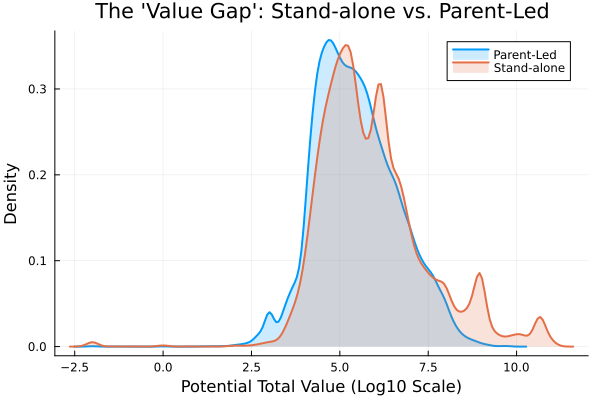

In [14]:
using StatsPlots

# 1. Filter and TRANSFORM in one go
# We create a new column called :log_value
plot_df = filter(row -> !ismissing(row.potential_total_value_of_award) && 
                        row.potential_total_value_of_award > 0, df_latest)

# Transform the data itself
plot_df.log_value = log10.(plot_df.potential_total_value_of_award)

# 2. Plot the pre-transformed data
@df plot_df density(
    :log_value, 
    group = :is_standalone, 
    title = "The 'Value Gap': Stand-alone vs. Parent-Led",
    xlabel = "Potential Total Value (Log10 Scale)",
    ylabel = "Density",
    label = ["Parent-Led" "Stand-alone"],
    fill = (0, 0.2),
    lw = 2
)

# Extracting just the 50 headers

# More data extraction. 
what i want this to do:
1. go thru datafile and keep only the columns i have listed in the column name column
2. get the datatypes of each column 
3. i have the ideal datatypes of each column listed in the column titled "ideal datatype" (float, date, or string)
4. convert the data in that column to its ideal type and do all steps necessary to do that
5. count the number of unique values in each column
6. if the count of unique values is low (less than 25) i want to see the proportion of each value in each category so i can make determination about what to do next. make plots for all of them, where each category is sorted high to low (bar chart or pie chart - whichever you think is better). if the number of unique values is higher than that, display a list of these columns 

# Phase 1
This phase focuses on memory efficiency. We only pull the columns you want and force them into the "Ideal" types you defined.

The Strategy:

Floats: Remove $, ,, and ( ) (often used for negative numbers in accounting).

Dates: Standardize into Julia Date objects. If a date is malformed, it becomes missing rather than crashing the script.

Strings: Force lowercase and trim whitespace to eliminate the "invisible duplicates" we discussed.

In [12]:
using CSV, DataFrames, Dates

# Load your manual instruction file
# Replace "my_column_list.csv" with your actual filename
instructions_df = CSV.read("data/manually_selected_column_headers_and_datatype_v3.csv", DataFrame)

# Convert the two columns into a Dictionary
# This assumes your CSV headers are exactly "column name" and "ideal type"
column_map = Dict(
    row["column name"] => Symbol(lowercase(strip(string(row["ideal type"])))) 
    for row in eachrow(instructions_df)
)

# Preview the map to make sure it looks right
println("Targeting $(length(keys(column_map))) columns.")

Targeting 41 columns.


In [13]:
instructions_df

Row,column name,ideal type
,String,String7
1,potential_total_value_of_award,float
2,period_of_performance_start_date,date
3,period_of_performance_current_end_date,date
4,period_of_performance_potential_end_date,date
5,solicitation_date,string
6,awarding_office_code,string
7,funding_office_code,string
8,object_classes_funding_this_award,string
9,program_activities_funding_this_award,string


In [14]:
function clean_and_load(data_filepath, col_map)
    println("Loading data from $data_filepath...")
    # Load only selected columns
    df = CSV.read(data_filepath, DataFrame, select=collect(keys(col_map)), stringtype=String)
    
    for (col_str, type) in col_map
        sym = Symbol(col_str)
        
        if type == :float
            df[!, sym] = map(x -> begin
                if ismissing(x) || x == "" || x == "NULL" return missing end
                s = replace(string(x), r"[$,\s]" => "")
                if startswith(s, "(") && endswith(s, ")") s = "-" * s[2:end-1] end
                tryparse(Float64, s)
            end, df[!, sym])

        elseif type == :integer
            df[!, sym] = map(x -> begin
                if ismissing(x) || x == "" return missing end
                # Strip commas in case integers are formatted (e.g., 1,000)
                s = replace(string(x), r"[,\s]" => "")
                tryparse(Int64, s)
            end, df[!, sym])

        elseif type == :boolean
            # Standardizes Y/N/Blank to true/false/missing
            df[!, sym] = map(x -> begin
                if ismissing(x) || x == "" return missing end
                s = uppercase(strip(string(x)))
                if s == "Y" || s == "TRUE" || s == "1" return true
                elseif s == "N" || s == "FALSE" || s == "0" return false
                else return missing end
            end, df[!, sym])
            
        elseif type == :date
            df[!, sym] = map(x -> begin
                if ismissing(x) || x == "" return missing end
                tryparse(Date, first(string(x), 10)) 
            end, df[!, sym])
            
        elseif type == :string
            df[!, sym] = map(x -> ismissing(x) ? missing : strip(lowercase(string(x))), df[!, sym])
        end
    end
    
    println("Load complete. Final dimensions: $(size(df))")
    return df
end

clean_and_load (generic function with 1 method)

In [27]:
# Execute the load
# Replace "usa_spending_full.csv" with your actual data file
input_data_csv = "backups/extracted/FY2025/All_Contracts_PrimeTransactions_2026-01-27_H16M01S18_1.csv"
df = clean_and_load(input_data_csv, column_map)



Loading data from backups/extracted/FY2025/All_Contracts_PrimeTransactions_2026-01-27_H16M01S18_1.csv...
Load complete. Final dimensions: (107988, 41)


Row,potential_total_value_of_award,period_of_performance_start_date,period_of_performance_current_end_date,period_of_performance_potential_end_date,solicitation_date,awarding_office_code,funding_office_code,object_classes_funding_this_award,program_activities_funding_this_award,foreign_funding_description,recipient_uei,recipient_duns,cage_code,prime_award_transaction_place_of_performance_state_fips_code,award_or_idv_flag,award_type_code,idv_type_code,multiple_or_single_award_idv_code,type_of_idc_code,type_of_contract_pricing_code,product_or_service_code,contract_bundling_code,naics_code,dod_acquisition_program_code,information_technology_commercial_item_category_code,extent_competed_code,solicitation_procedures_code,type_of_set_aside_code,evaluated_preference_code,research_code,other_than_full_and_open_competition_code,number_of_offers_received,commercial_item_acquisition_procedures_code,fed_biz_opps_code,price_evaluation_adjustment_preference_percent_difference,labor_standards_code,cost_or_pricing_data_code,government_furnished_property_code,undefinitized_action_code,performance_based_service_acquisition_code,multi_year_contract_code
,Float64,Date,Date?,Date?,SubStrin…?,SubStrin…,SubStrin…,SubStrin…?,SubStrin…?,SubStrin…,SubStrin…,Missing,SubStrin…?,Int64?,SubStrin…,SubStrin…?,SubStrin…?,SubStrin…?,SubStrin…?,SubStrin…,SubStrin…,SubStrin…?,Int64?,SubStrin…?,SubStrin…?,SubStrin…?,SubStrin…?,SubStrin…?,SubStrin…?,SubStrin…?,SubStrin…?,Int64?,SubStrin…,Bool?,Float64?,Bool?,Bool?,Bool,SubStrin…,Bool?,Bool?
1,1.82167e8,2022-11-04,2025-11-30,2032-11-30,2020-02-26,fa2263,f4ftml,25.7: operation and maintenance of equipment,0004: administration and service-wide activities,not applicable,lnkfgdhu6qz4,missing,2h984,39,award,d,missing,missing,missing,j,h266,h,541380,000,z,a,np,none,none,missing,missing,5,d,true,0.0,true,false,true,x,true,false
2,3.43816e7,2025-03-10,2029-03-09,2029-03-09,2024-10-17,fa2384,f4f4rh,25.7: operation and maintenance of equipment,0001: operation and maintenance,not applicable,c8zlj61yj528,missing,13993,39,award,d,missing,missing,missing,u,ac13,h,541715,000,z,a,br,none,none,missing,missing,1,d,missing,0.0,missing,true,false,x,true,false
3,3.61094e5,2025-02-19,2025-08-18,2026-02-18,2025-01-16,fa2396,f4fbbk,missing,missing,not applicable,kkz6vv15mbk7,missing,3yks5,39,award,d,missing,missing,missing,j,r499,h,541330,000,z,d,np,none,none,missing,one,1,a,missing,0.0,false,true,false,x,true,false
4,1.1e8,2023-07-28,missing,missing,2023-05-18,fa2280,f4fbeq,missing,missing,not applicable,hfbuflscbyl9,missing,8nt92,missing,idv,missing,b,s,b,1,ac32,h,541715,missing,missing,b,sss,none,none,sr3,oth,1,a,missing,missing,missing,false,false,x,true,false
5,5.23232e6,2024-09-16,2025-09-15,2026-09-15,2024-01-29,fa2401,f1afm1,25.5: research and development contracts,0020: undistributed,not applicable,ktmajcy6jxm3,missing,5ute0,6,award,d,missing,missing,missing,b,ac13,h,541715,000,z,c,sss,none,none,missing,one,1,d,missing,0.0,true,true,false,x,false,false
6,4.85381e5,2024-09-13,2025-05-05,2025-05-05,missing,fa2550,f3r1c0,missing,missing,not applicable,yztlalwm4uc7,missing,06ap0,46,award,b,missing,missing,missing,j,7e20,h,334118,000,a,f,sp1,sba,none,missing,missing,5,a,true,missing,missing,missing,false,x,missing,missing
7,10000.0,2025-07-20,2025-08-01,2025-08-01,missing,fa2384,f4fbat,missing,missing,not applicable,kc3ch2msk7q3,missing,85ld7,32,award,b,missing,missing,missing,j,ac14,h,541715,000,z,a,np,none,none,missing,missing,18,a,missing,missing,missing,missing,false,x,true,missing
8,5.35e7,2022-02-01,missing,missing,2021-02-22,fa2521,f3k0ka,missing,missing,not applicable,hwzds28aqb68,missing,856r8,missing,idv,missing,b,s,b,1,r425,h,541715,missing,missing,d,np,sba,none,missing,missing,2,d,missing,missing,true,false,true,x,true,true
9,4.51848e6,2023-09-25,2025-07-31,2025-07-31,2023-05-11,fa2521,f3k3dh,32.0: land and structures,0001: operating forces,not applicable,vukdaxzbmkc5,missing,59xc9,12,award,d,missing,missing,missing,j,z2pz

In [30]:
described_df = describe(df, :eltype, :nmissing, :nunique, :min, :max)

Row,variable,eltype,nmissing,nunique,min,max
,Symbol,Type,Int64,Union…,Any,Any
1,potential_total_value_of_award,Float64,0,,-4.94756e8,9.2e10
2,period_of_performance_start_date,Date,0,3109,1996-06-15,2032-09-29
3,period_of_performance_current_end_date,"Union{Missing, Date}",8966,3035,2002-12-31,2099-12-31
4,period_of_performance_potential_end_date,"Union{Missing, Date}",8966,3499,2002-12-31,2099-12-31
5,solicitation_date,"Union{Missing, SubString{String}}",31932,2412,2002-05-02,2025-09-30
6,awarding_office_code,SubString{String},0,327,fa0021,fa9550
7,funding_office_code,SubString{String},0,4009,70z008,wt6khu
8,object_classes_funding_this_award,"Union{Missing, SubString{String}}",70413,457,"11.1: full-time permanent;23.3: communications, utilities, and miscellaneous charges","41.0: grants, subsidies, and contributions"
9,program_activities_funding_this_award,"Union{Missing, SubString{String}}",70900,1094,0000: lease of dod real property;0001: operating forces;0004: administration and service-wide activities;0020: undistributed;00rb: reimbursable program,optn: field is optional prior to fy21


In [18]:
CSV.write("data/phase_1_analysis.csv", described_df; transform=(col, val) -> something(val, missing))

"data/phase_1_analysis.csv"

# Phase 2: Frequency Stats & The "Chop List"
This is where we apply the 5% Rule and look for Near-Zero Variance.
## The Strategy:
We calculate the "Sparsity" (Percentage of missing data).

In [ ]:
function analyze_sparsity_and_uniques(df)
    analysis_results = DataFrame(
        Column = Symbol[], 
        Unique_Count = Int[], 
        Missing_Pct = Float64[], 
        Top_Value_Pct = Float64[]
    )
    
    for col in names(df)
        vals = filter(!ismissing, df[!, col])
        u_count = length(unique(vals))
        m_pct = (count(ismissing, df[!, col]) / nrow(df)) * 100
        
        # Calculate how dominant the most common value is
        top_val_pct = 0.0
        if !isempty(vals)
            top_val_pct = (maximum(values(countmap(vals))) / length(vals)) * 100
        end
        
        push!(analysis_results, (Symbol(col), u_count, m_pct, top_val_pct))
    end
    return analysis_results
end

Phase 3: Visual Decision Breaks (Bar Charts vs. Lists)
For cost modeling, Bar Charts are superior to Pie Charts because they allow you to clearly see the "Long Tail" of smaller agencies or contractors.

The Strategy:

For < 25 Uniques: Generate a sorted horizontal bar chart. If the "Top 1" value is > 95%, the script will label it as a "Candidate for Deletion" (Near-Zero Variance).

For > 25 Uniques: Provide a "Pareto List" showing the Top 10 values and their cumulative percentage.

Phase 4: Feature Engineering (The Final Whittling)
This is where we consolidate the business flags and calculate time durations.

The Strategy:

Date Subtraction: Create duration_days.

Business Super-Flag: Create is_special_status.

The "Othering": For columns like recipient_name, any ID not in the Top 80% of volume gets renamed to "other_contractor".

Summary of Breaks
Break 1 (After Phase 2): You review the Sparsity Table. If a column you thought was important is 90% missing, you decide whether to drop it now.

Break 2 (After Phase 3): You look at the Bar Charts. You will see flags that are 99% "No." You can then run a command to drop those specific columns.

Break 3 (After Phase 4): You look at the final column list to ensure the "Othering" didn't delete too much detail.